In [1]:
import os
import sys
import pandas as pd
import numpy as np
from sklearn.preprocessing import Normalizer
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_selection import mutual_info_classif

In [2]:
# MAGIC COMMANDS
get_ipython().magic(u'matplotlib inline')

In [3]:
print(sys.version)

3.6.3 |Anaconda, Inc.| (default, Oct 15 2017, 03:27:45) [MSC v.1900 64 bit (AMD64)]


In [4]:
path = os.getcwd()

In [5]:
path = path + "\\..\\data\\" 

In [6]:
# LOAD DATA FILES
data = pd.read_csv(path + 'data.csv')

In [7]:
#######################
# EXPLORATORY ANALYSIS
#######################

In [8]:
data.shape

(2017, 17)

In [9]:
# Get statistics about the features
desc = data.describe()
#desc.to_csv('describe.csv')
desc


,id,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target
count,2017.000000,2017.000000,2017.000000,2.017000e+03,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000
mean,1008.000000,0.187590,0.618422,2.463062e+05,0.681577,0.133286,5.342588,0.190844,-7.085624,0.612295,0.092664,121.603272,3.968270,0.496815,0.505702
std,582.402066,0.259989,0.161029,8.198181e+04,0.210273,0.273162,3.648240,0.155453,3.761684,0.487347,0.089931,26.685604,0.255853,0.247195,0.500091
min,0.000000,0.000003,0.122000,1.604200e+04,0.014800,0.000000,0.000000,0.018800,-33.097000,0.000000,0.023100,47.859000,1.000000,0.034800,0.000000
25%,504.000000,0.009630,0.514000,2.000150e+05,0.563000,0.000000,2.000000,0.092300,-8.394000,0.000000,0.037500,100.189000,4.000000,0.295000,0.000000
50%,1008.000000,0.063300,0.631000,2.292610e+05,0.715000,0.000076,6.000000,0.127000,-6.248000,1.000000,0.054900,121.427000,4.000000,0.492000,1.000000
75%,1512.000000,0.265000,0.738000,2.703330e+05,0.846000,0.054000,9.000000,0.247000,-4.746000,1.000000,0.108000,137.849000,4.000000,0.691000,1.000000
max,2016.000000,0.995000,0.984000,1.004627e+06,0.998000,0.976000,11.000000,0.969000,-0.307000,1.000000,0.816000,219.331000,5.000000,0.992000,1.000000


In [10]:
# Get name and type of features
for x in data.columns:
    print (x, data[x].dtype)
print ('number of features: ', len(data.columns))


id int64
acousticness float64
danceability float64
duration_ms int64
energy float64
instrumentalness float64
key int64
liveness float64
loudness float64
mode int64
speechiness float64
tempo float64
time_signature int64
valence float64
target int64
song_title object
artist object
number of features:  17


In [11]:
# Deal with missing values: not missing values
for x in data.columns:
    if data[x].isnull().any():
        print(x)

In [12]:
# check if there is any repeated ID, which would imply to tidy the data set:
id_counts = data['id'].value_counts().sort_index() # count the number of occurrences of each ID
max(id_counts) # if the max value is 1, then there are no repeated IDs = 1 row for each observation.

1

In [13]:
# Percentage of target == 1: ~ 4% --> very unbalanced!
float(len(data[data['target']==1]))/len(data['target']) * 100

50.57015369360436

In [14]:
#######################
# PREPROCESSING
#######################

In [15]:
# shuffle dataset
data = data.sample(frac=1).reset_index(drop=True)

In [16]:
id = data["id"]

In [17]:
# Remove IDs
data = data.drop(['id', "song_title", "artist"], axis=1)

In [18]:
normalized = preprocessing.MinMaxScaler().fit(data).transform(data)

In [19]:
df = pd.DataFrame(normalized)

In [20]:
df.columns = data.columns

In [21]:
data = df

In [22]:

# Remove constant features
# "Constant features can lead to errors in some models and obviously provide no information in the training set that can be learned from."
remove = []
count_constants = 0
for col in data.columns:
    if data[col].values.std() == 0: # pandas.series std() is not correct, use numpy std() instead (.values.std() instead of std())
        #print col
        remove.append(col)
        count_constants += 1
data.drop(remove, axis=1, inplace=True)
#test_df.drop(remove, axis=1, inplace=True)
print ('number of constant features removed: ', count_constants)

number of constant features removed:  0


In [23]:
# Remove duplicated columns
remove = []
c = data.columns
count_duplicated = 0
for i in range(len(c)-1):
    v = data[c[i]].values
    for j in range(i+1,len(c)):
        if np.array_equal(v,data[c[j]].values):
            #print c[j]
            remove.append(c[j])
            count_duplicated += 1

data.drop(remove, axis=1, inplace=True)
#test_df.drop(remove, axis=1, inplace=True)
print ('number of duplicated features removed: ', count_duplicated)


number of duplicated features removed:  0


In [24]:
####################
# FEATURE SELECTION
####################

In [25]:
# Remove features with low variance:
from sklearn.feature_selection import VarianceThreshold
def VarianceThreshold_selector(data, th):
    #Select Model
    selector = VarianceThreshold(th) #Defaults to 0.0, e.g. only remove features with the same value in all samples
    #Fit the Model
    selector.fit(data)
    features = selector.get_support(indices = True) #returns an array of integers corresponding to nonremoved features
    print(features)
    features = data.columns[features] #Array of all nonremoved features' names
    #Format and Return
    selector = pd.DataFrame(selector.transform(data))
    selector.columns = features
    return selector

In [26]:
(data.describe().loc['std']*data.describe().loc['std']).min()

0.0040913089434253197

In [27]:
# train_vth = pd.concat([VarianceThreshold_selector(train.iloc[:,:-1], 0.003), train.iloc[:,-1]], axis=1)


In [28]:
# union = pd.concat([train, , test], axis = 0)

In [29]:
X, y = data.iloc[:,:-1], data.iloc[:, -1]

In [30]:
# univariate feature selection
# Remove features which are not correlated to the target variable by using univariate feature selection, keep the top 5%
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_classif
selector = SelectPercentile(score_func = f_classif, percentile = 35)
selector = selector.fit(X, y)
# pd.DataFrame([selector.get_support(), selector.scores_]).transpose()
X_reduced = selector.transform(X)
X_reduced = pd.DataFrame(X_reduced)
X_reduced.columns = X.columns[selector.get_support()]

In [31]:
# Mutual information feature selection
mutual_info = mutual_info_classif(X, y, discrete_features='auto')

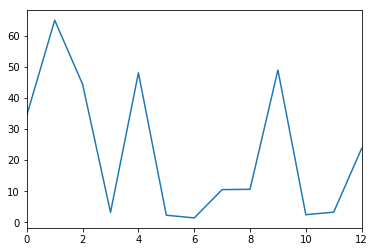

In [32]:
# Scores univariate feature selection
pd.Series(selector.scores_).plot()

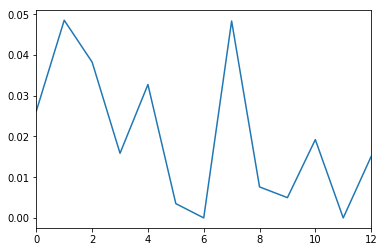

In [33]:
# Scores MI feature selection
pd.Series(mutual_info).plot()

In [34]:
normalized_MI = (mutual_info - min(mutual_info))/(max(mutual_info)  - min(mutual_info)) #preprocessing.MinMaxScaler().fit(pd.DataFrame(mutual_info)).transform(pd.DataFrame(mutual_info))

In [35]:
normalized_univariante = (selector.scores_ - min(selector.scores_))/(max(selector.scores_)  - min(selector.scores_)) #preprocessing.MinMaxScaler().fit(pd.DataFrame(selector.scores_)).transform(pd.DataFrame(selector.scores_))

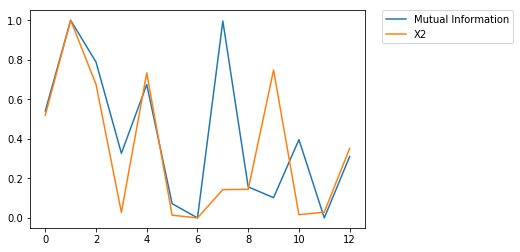

In [36]:
plt.plot(normalized_MI, label="Mutual Information")
plt.plot(normalized_univariante, label="X2")
# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


In [37]:
normalized_MI

array([ 0.54090188,  1.        ,  0.78836995,  0.32691906,  0.67476128,
        0.07226664,  0.        ,  0.9959864 ,  0.15690839,  0.10254763,
        0.39604978,  0.        ,  0.31057232])

In [38]:
X_reduced_mutual_indexes = normalized_MI > 0.5
X_reduced_mutual_indexes

array([ True,  True,  True, False,  True, False, False,  True, False,
       False, False, False, False], dtype=bool)

In [39]:
X_reduced_chi2_indexes = normalized_univariante > 0.5
X_reduced_chi2_indexes

array([ True,  True,  True, False,  True, False, False, False, False,
        True, False, False, False], dtype=bool)

In [40]:
X_reduced_mutual_chi2_indexes = X_reduced_mutual_indexes & X_reduced_chi2_indexes
X_reduced = X.loc[:,X_reduced_mutual_chi2_indexes]

In [41]:
X.columns[10]

'tempo'

In [42]:
#for feature in X:
#plt.subplot(121)
#plt.scatter(X['acousticness'],y)
#plt.subplot(122)
#plt.scatter(X['loudness'],y)


In [43]:
# var = 'tempo'
# fit = np.polyfit(X[var],y,1)
# fit_fn = np.poly1d(fit) 
# # fit_fn is now a function which takes in x and returns an estimate for y

# plt.plot(X[var],y, 'yo', X[var], fit_fn(X[var]), '--k')
# plt.xlim(0, 1)
# plt.ylim(0, 1)


In [44]:
# data[data['target'] == 1][var].hist()

In [45]:
# data[data['target'] == 0][var].hist()

In [46]:
# SPLIT TRAIN, TEST AND VALIDATION
#X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.20, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42)
print ('Tamaño del dataset train: ' + str((X_train.shape[0]/data.shape[0])*100))
print ('Tamaño del dataset test: ' + str((X_test.shape[0]/data.shape[0])*100))
print ('Tamaño del dataset validation: ' + str((X_val.shape[0]/data.shape[0])*100))

train = pd.concat([X_train,y_train],axis=1)
test = pd.concat([X_test,y_test],axis=1)
validation = pd.concat([X_val,y_val],axis=1)

print('Porcentajes de labels == 1 en el dataset train: ' + str(float(len(train[train['target']==1]))/len(train['target']) * 100))
print('Porcentajes de labels == 1 en el dataset test: ' + str(float(len(test[test['target']==1]))/len(test['target']) * 100))
print('Porcentajes de labels == 1 en el dataset validation: ' + str(float(len(validation[validation['target']==1]))/len(validation['target']) * 100))

Tamaño del dataset train: 63.95637084779375
Tamaño del dataset test: 20.029747149231532
Tamaño del dataset validation: 16.013882002974714
Porcentajes de labels == 1 en el dataset train: 51.3953488372093
Porcentajes de labels == 1 en el dataset test: 47.277227722772274
Porcentajes de labels == 1 en el dataset validation: 51.39318885448917


In [147]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

# BASE CLASSIFIERS

#clf = LogisticRegression(C=1, solver = 'sag', class_weight = 'balanced', max_iter= 200)
# 0.70631677860938813

# clf = GaussianNB(priors = [0.7, 0.3])
# 0.69875089344784536

#clf = svm.SVC(kernel='linear')
# 0.70618762598849805

#clf = KNeighborsClassifier(n_neighbors = 5, weights = 'distance', algorithm = 'auto', p = 2)
# 0.75476512291348463

#clf = tree.DecisionTreeClassifier(criterion  = 'gini')
# 0.68585244688249636

# clf = MLPClassifier(solver = 'lbfgs', activation = 'relu', batch_size = X.shape[0], hidden_layer_sizes =(100,100,100), shuffle = False, random_state=1)
# 0.8063421171784787

# ENSEMBLE CLASSIFIERS
#clf = GradientBoostingClassifier()
# 0.84466821558408323

#clf = AdaBoostClassifier()
# 0.78610948018157401


In [148]:
clf.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size=2017, beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 100, 100), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=False,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [149]:
roc_auc_score(y_val, clf.predict(X_val))

0.7374146266595043

In [156]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, pd.concat([X_train, X_val], axis = 0), pd.concat([y_train, y_val], axis = 0), cv=5, scoring='roc_auc', verbose=5,n_jobs=5)
np.mean(scores)

[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    2.9s remaining:    4.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    5.0s finished


0.80231289059851729